# ⛅️ Project 02: 날씨 데이터 분류
---
## 주제: 날씨 데이터 분류 (사전 훈련 모델 or 미세 조정(sequence) , (저용량))
---
### 목표 (Target)
- **흐림**
- **비**
- **맑음⛅️**
- **해돋이**


### 목차
1. 이미지 불러오기.
2. 데이터 프레임으로 file 경로 및 target 분류.
3. 데이터셋 미세 조정을 통한 데이터 증강 및 메모리 효율성 확보.
4. 데이터 훈련.
5. 데이터 검증.
6. 결론.

## 1. 이미지 불러오기

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/p_Multi-class Weather Dataset/'

IMAGE_SIZE = 128
BATCH_SIZE = 64

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 1125 images belonging to 4 classes.
{'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'Cloudy', 1: 'Rain', 2: 'Shine', 3: 'Sunrise'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

w_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
w_df

,file_paths,target_names,targets
0,./datasets/p_Multi-class Weather Dataset/Cloud...,Cloudy,0
1,./datasets/p_Multi-class Weather Dataset/Cloud...,Cloudy,0
2,./datasets/p_Multi-class Weather Dataset/Cloud...,Cloudy,0
3,./datasets/p_Multi-class Weather Dataset/Cloud...,Cloudy,0
4,./datasets/p_Multi-class Weather Dataset/Cloud...,Cloudy,0
...,...,...,...
1120,./datasets/p_Multi-class Weather Dataset/Sunri...,Sunrise,3
1121,./datasets/p_Multi-class Weather Dataset/Sunri...,Sunrise,3
1122,./datasets/p_Multi-class Weather Dataset/Sunri...,Sunrise,3
1123,./datasets/p_Multi-class Weather Dataset/Sunri...,Sunrise,3


In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(w_df.file_paths, 
                 w_df.targets, 
                 stratify=w_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
3    286
0    240
2    202
1    172
Name: count, dtype: int64
targets
3    71
0    60
2    51
1    43
Name: count, dtype: int64


In [6]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify = train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
3    229
0    192
2    162
1    137
Name: count, dtype: int64
targets
3    57
0    48
2    40
1    35
Name: count, dtype: int64
targets
3    71
0    60
2    51
1    43
Name: count, dtype: int64


## 2. 데이터 프레임 분리

In [7]:
train_df = w_df.iloc[train_images.index].reset_index(drop=True)
validation_df = w_df.iloc[validation_images.index].reset_index(drop=True)
test_df = w_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(720, 3)
(180, 3)
(225, 3)


## 3. 데이터프레임 이미지 전처리

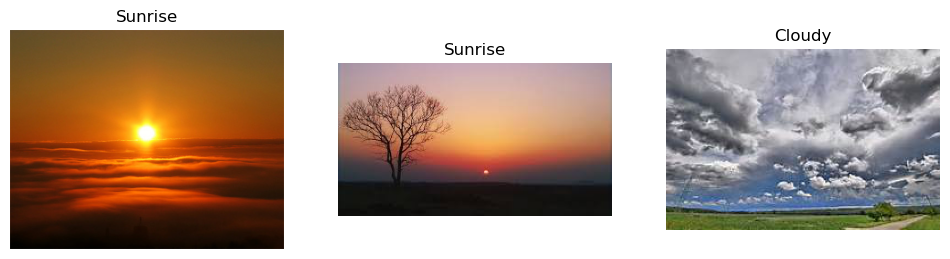

In [12]:
import cv2
import matplotlib.pyplot as plt

train_image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[10]), cv2.COLOR_BGR2RGB)
validation_image = cv2.cvtColor(cv2.imread(validation_df.file_paths.iloc[11]), cv2.COLOR_BGR2RGB)
test_image = cv2.cvtColor(cv2.imread(test_df.file_paths.iloc[10]), cv2.COLOR_BGR2RGB)


figure, axs = plt.subplots(figsize= (12,12), nrows=1, ncols=3)

axs[0].imshow(train_image)
axs[0].set_title(train_df.target_names.iloc[10])
axs[0].axis('off')

axs[1].imshow(validation_image)
axs[1].set_title(validation_df.target_names.iloc[11])
axs[1].axis('off')

axs[2].imshow(test_image)
axs[2].set_title(test_df.target_names.iloc[10])
axs[2].axis('off')

plt.show()

## 4-1. 이미지의 개수가 적기 데이터 증강 및 미세 조정 사용, 훈련
- (ShiftScaleRotate, HorizontalFlip, RandomBrightnessContrast)

In [13]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 128
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            try:
                image = cv2.imread(file_paths_batch[i])
                if image is None:
                    raise ValueError(f"Image not found at path: {file_paths_batch[i]}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                if self.aug is not None:
                    image = self.aug(image=image)['image']
                if self.preprocess is not None:
                    image = self.preprocess(image)
                results_batch[i] = image
            except Exception as e:
                print(f"Error processing image {file_paths_batch[i]}: {e}")
                continue

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)  

In [14]:
import albumentations as A
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input


IMAGE_SIZE = 128
BATCH_SIZE = 64


train_file_paths = train_df['file_paths'].values
train_targets = pd.get_dummies(train_df['targets']).values

validation_file_paths = validation_df['file_paths'].values
validation_targets = pd.get_dummies(validation_df['targets']).values

test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values


aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, p=0.5)
],p=0.7)


train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size = BATCH_SIZE,
                        aug = aug,
                        preprocess = mobilenet_preprocess_input, 
                        shuffle= True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size = BATCH_SIZE,
                        preprocess = mobilenet_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size = BATCH_SIZE,
                        preprocess = mobilenet_preprocess_input)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = 128
BATCH_SIZE = 32

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(4, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/project02/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_21813/1050060168.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,322,238 (8.86 MB)

 Trainable params: 2,288,126 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [57]:
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - acc: 0.3980 - loss: 1.5929Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.4093 - loss: 1.5575 - val_acc: 0.7278 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - acc: 0.8225 - loss: 0.4943Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.8248 - loss: 0.4902 - val_acc: 0.6611 - val_loss: 2.1815 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - acc: 0.9307 - loss: 0

In [60]:
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - acc: 0.9692 - loss: 0.0970Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.9692 - loss: 0.0973 - val_acc: 0.7833 - val_loss: 1.4740 - learning_rate: 1.0000e-05
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - acc: 0.9716 - loss: 0.1084Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 988ms/step - acc: 0.9712 - loss: 0.1090 - val_acc: 0.8111 - val_loss: 1.1435 - learning_rate: 1.0000e-05
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - acc: 0.975

In [61]:
model.evaluate(test_dataset, batch_size=64)

Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - acc: 0.8035 - loss: 1.2686


[1.2777822017669678, 0.804444432258606]

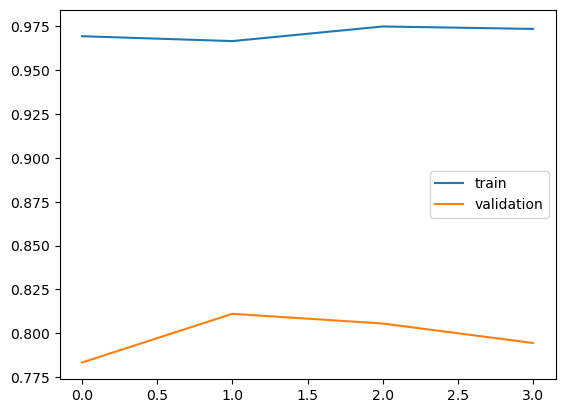

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 4-1-1. 과적합이 발생되어 모델에 대하여 데이터증강의 변수를 증가시켜 추가 일반화하여 훈련 진행

In [63]:
import albumentations as A
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input


IMAGE_SIZE = 128
BATCH_SIZE = 64


train_file_paths = train_df['file_paths'].values
train_targets = pd.get_dummies(train_df['targets']).values

validation_file_paths = validation_df['file_paths'].values
validation_targets = pd.get_dummies(validation_df['targets']).values

test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values


aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GridDistortion(p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.5),
    A.OneOf([
        A.ColorJitter(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5) 
    ], p=1)        
], p=0.5)

train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size = BATCH_SIZE,
                        aug = aug,
                        preprocess = mobilenet_preprocess_input, 
                        shuffle= True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size = BATCH_SIZE,
                        preprocess = mobilenet_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size = BATCH_SIZE,
                        preprocess = mobilenet_preprocess_input)

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = 128
BATCH_SIZE = 32

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(4, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [65]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_21813/1050060168.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,322,238 (8.86 MB)

 Trainable params: 2,288,126 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [66]:
N_EPOCHS = 40

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - acc: 0.4173 - loss: 1.4795Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - acc: 0.4291 - loss: 1.4499 - val_acc: 0.8444 - val_loss: 0.5174 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - acc: 0.8468 - loss: 0.4513Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.8488 - loss: 0.4461 - val_acc: 0.7944 - val_loss: 1.2431 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - acc: 0.9190 - loss: 0

In [67]:
model.evaluate(test_dataset, batch_size=32)

Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - acc: 0.7439 - loss: 2.0040


[2.1451807022094727, 0.7244444489479065]

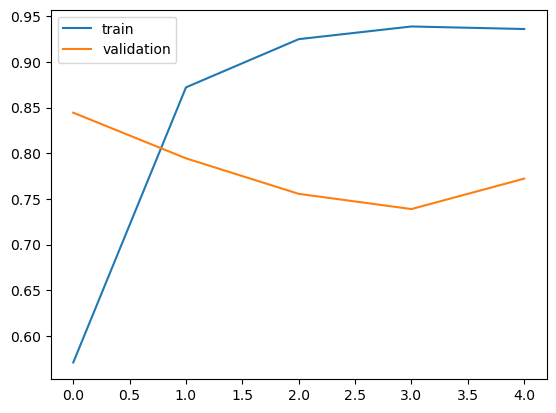

In [68]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

In [69]:
N_EPOCHS = 40

history = model.fit(train_dataset,
                    batch_size=16,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - acc: 0.9481 - loss: 0.1704Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9481 - loss: 0.1704 - val_acc: 0.7556 - val_loss: 1.8554 - learning_rate: 1.0000e-05
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - acc: 0.9397 - loss: 0.1587Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 966ms/step - acc: 0.9402 - loss: 0.1588 - val_acc: 0.7222 - val_loss: 1.9088 - learning_rate: 1.0000e-05
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - acc: 0.939

In [76]:
model.evaluate(test_dataset, batch_size=64)

Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - acc: 0.7583 - loss: 1.9335


[2.144680976867676, 0.742222249507904]

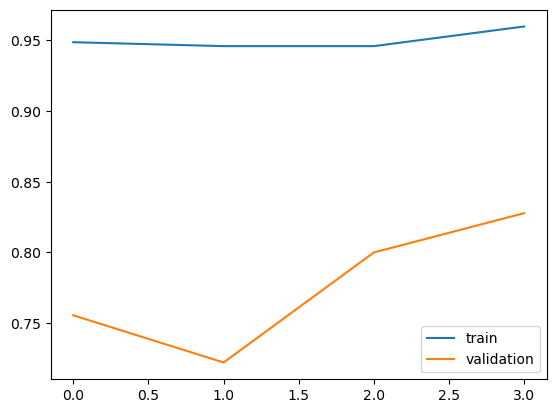

In [71]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

In [77]:
N_EPOCHS = 40

history = model.fit(train_dataset,
                    batch_size=64,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - acc: 0.9397 - loss: 0.1666Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.9404 - loss: 0.1659 - val_acc: 0.8167 - val_loss: 1.4929 - learning_rate: 1.0000e-05
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - acc: 0.9482 - loss: 0.1874Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 945ms/step - acc: 0.9482 - loss: 0.1876 - val_acc: 0.8000 - val_loss: 1.7620 - learning_rate: 1.0000e-05
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - acc: 0.933

In [78]:
model.evaluate(test_dataset, batch_size=64)

Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - acc: 0.8098 - loss: 1.4607


[1.637901782989502, 0.7822222113609314]

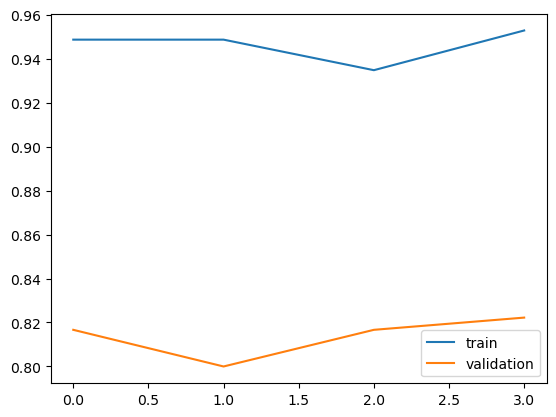

In [79]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 4-2. 전반적인 수치가 높게 나와 다른 모델 사용
- xception
- 모델의 일반화를 위해 데이터 증강 내용 증가 (3-> 7)


In [19]:
import albumentations as A
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input


IMAGE_SIZE = 128
BATCH_SIZE = 64


train_file_paths = train_df['file_paths'].values
train_targets = pd.get_dummies(train_df['targets']).values

validation_file_paths = validation_df['file_paths'].values
validation_targets = pd.get_dummies(validation_df['targets']).values

test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values


aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GridDistortion(p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.5),
    A.OneOf([
        A.ColorJitter(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5) 
    ], p=1)        
], p=0.5)

train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size = BATCH_SIZE,
                        aug = aug,
                        preprocess = xception_preprocess_input, 
                        shuffle= True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size = BATCH_SIZE,
                        aug = aug,
                        preprocess = xception_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size = BATCH_SIZE,
                        aug = aug,
                        preprocess = xception_preprocess_input)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = 128
BATCH_SIZE = 32

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(4, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [82]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_7[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 20,964,134 (79.97 MB)

 Trainable params: 20,909,606 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [87]:
N_EPOCHS = 40

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.9752 - loss: 0.0985Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - acc: 0.9747 - loss: 0.0989 - val_acc: 0.8389 - val_loss: 1.8016 - learning_rate: 1.0000e-04
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.9819 - loss: 0.0855Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - acc: 0.9816 - loss: 0.0858 - val_acc: 0.9056 - val_loss: 0.9421 - learning_rate: 1.0000e-04
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.9832 - loss: 0.

In [88]:
model.evaluate(test_dataset, batch_size=32)

Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 875ms/step - acc: 0.9500 - loss: 0.1396


[0.143187016248703, 0.9466666579246521]

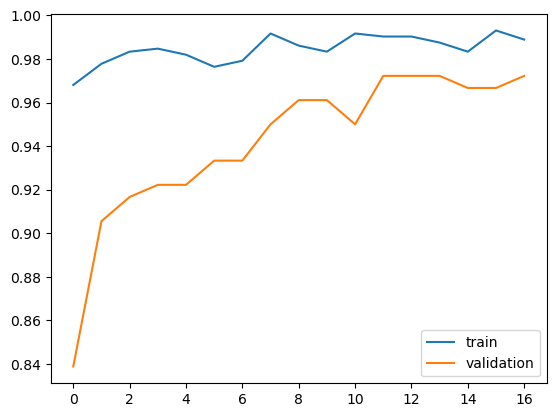

In [89]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = create_model(model_name='xception', verbose=True)
model.load_weight('./callback_files/project02/weights.017-0.1325-0.9889.weights.h5')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_24[0][0]    

 Total params: 20,964,134 (79.97 MB)

 Trainable params: 20,909,606 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

AttributeError: 'Functional' object has no attribute 'load_weight'

In [29]:
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

In [33]:
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.4554 - loss: 1.2411Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - acc: 0.4691 - loss: 1.2187 - val_acc: 0.5389 - val_loss: 2.6753 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.9440 - loss: 0.2735Error processing image ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Shine/shine131.jpg
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - acc: 0.9444 - loss: 0.2701 - val_acc: 0.5833 - val_loss: 7.9822 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.9629 - loss: 0.1387Error processin

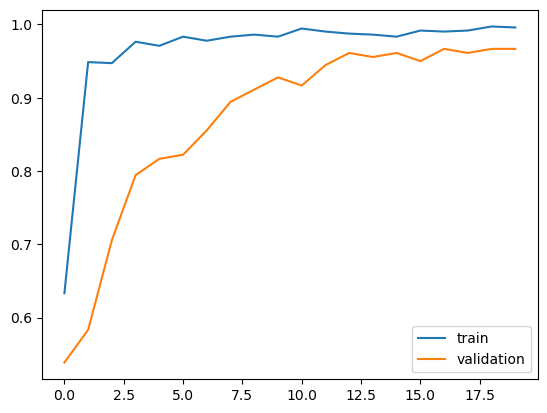

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 5. 데이터 검증

In [37]:
model.evaluate(test_dataset, batch_size=64)

Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step - acc: 0.9779 - loss: 0.1307


[0.18008263409137726, 0.9733333587646484]

Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
Error processing image ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg: Image not found at path: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Error loading image: ./datasets/p_Multi-class Weather Dataset/Rain/rain141.jpg


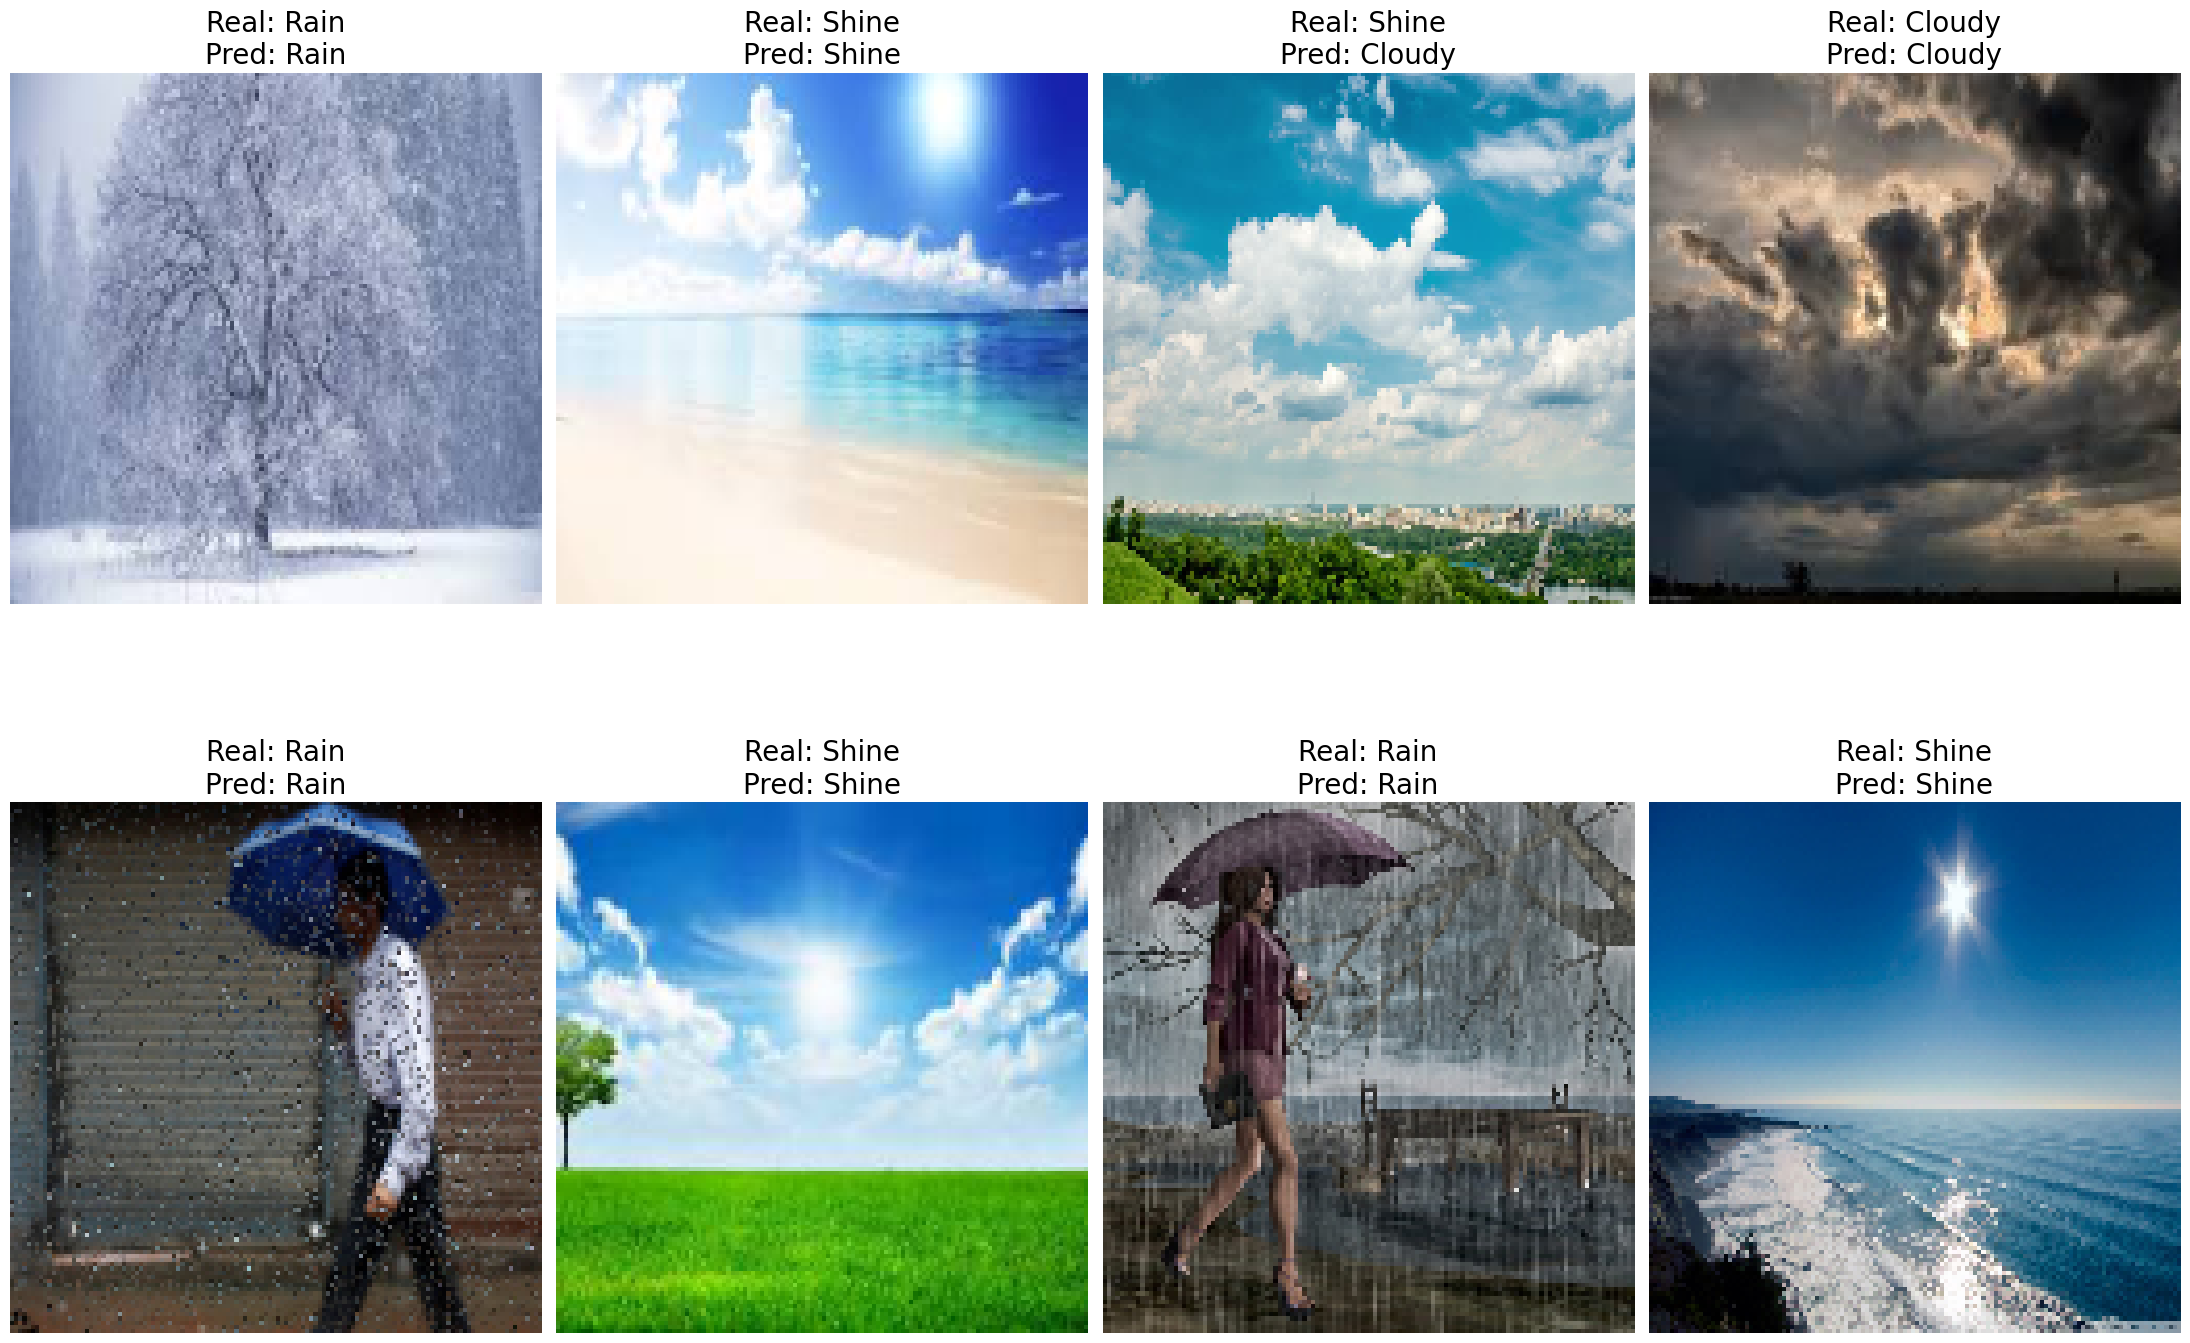

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 클래스 이름 정의
CLASS_NAMES = [
    "Cloudy",  # 0
    "Rain",  # 1
    "Shine",  # 2
    "Sunrise",  # 3
]

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
        # 오류 발생 시 빈 이미지 또는 대체 이미지 반환
        image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    return image

# 이미지 크기 설정
IMAGE_SIZE = 128
BATCH_SIZE = 64

# 이미지 시각화 함수 정의
def show_images(images, targets, predictions, nrows=2, ncols=4, fontsize=16):
    fig, axes = plt.subplots(figsize=(22, 16), nrows=nrows, ncols=ncols)
    axes = axes.flatten()  # axes를 1차원 배열로 변환

    for i in range(len(images)):
        ax = axes[i]
        img = images[i]
        ax.imshow(img)
        target = int(targets[i])
        prediction = int(predictions[i])
        ax.set_title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
        ax.axis('off')  # 축 숨기기

    # 사용되지 않는 subplot 숨기기
    for j in range(len(images), nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 테스트 데이터 제너레이터 생성
test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE,
                        preprocess=xception_preprocess_input)

# 모델 예측 수행
pred_probas = model.predict(test_dataset)
pred_classes = np.argmax(pred_probas, axis=1)

# 원본 이미지 로드
real_test_images = np.array([load_and_preprocess_image(fp) for fp in test_file_paths])

# 테스트 데이터와 예측값 시각화 (제너레이터에서 이미지와 타겟을 가져옴)
show_images(real_test_images[30:38], test_targets[30:38], pred_classes[30:38], fontsize=20)


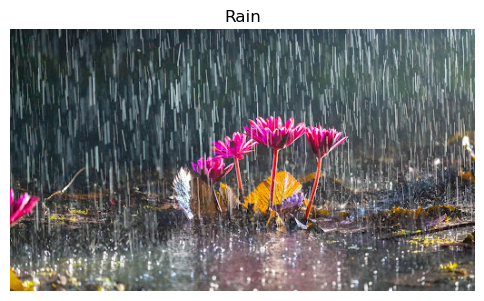

In [65]:
import matplotlib.pyplot as plt
import cv2

root_real_image_project02 = './images/real_project02.jpg'

real_image_project02 = cv2.cvtColor(cv2.imread(root_real_image_project02), cv2.COLOR_BGR2RGB)

figure, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)

ax.imshow(real_image_project02)
ax.set_title('Rain')
ax.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


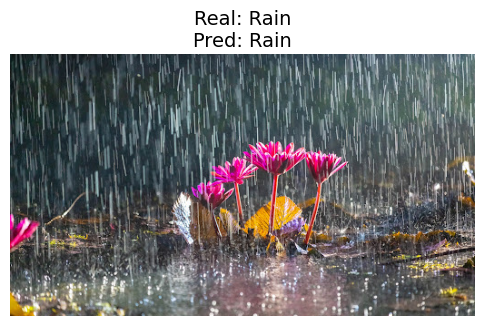

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

# 클래스 이름 정의
CLASS_NAMES = [
    "Cloudy",  # 0
    "Rain",  # 1
    "Shine",  # 2
    "Sunrise",  # 3
]

# 이미지 크기 설정
IMAGE_SIZE = 128

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
    return image

# 이미지 시각화 함수 정의
def show_single_image(image, target, prediction, fontsize=16):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
    plt.axis('off')
    plt.show()

# 실제 이미지 경로
root_real_image_project02 = './images/real_project02.jpg'
real_image_project02 = load_and_preprocess_image(root_real_image_project02, preprocess=xception_preprocess_input)
origin_image_project02 = cv2.cvtColor(cv2.imread(root_real_image_project02), cv2.COLOR_BGR2RGB)

# 모델 예측 수행
real_image_project02_expanded = np.expand_dims(real_image_project02, axis=0)  # 배치 차원을 추가
pred_probas = model.predict(real_image_project02_expanded)
pred_class = np.argmax(pred_probas, axis=1)[0]

# 실제 이미지 시각화
show_single_image(origin_image_project02, target=1, prediction=pred_class, fontsize=14)


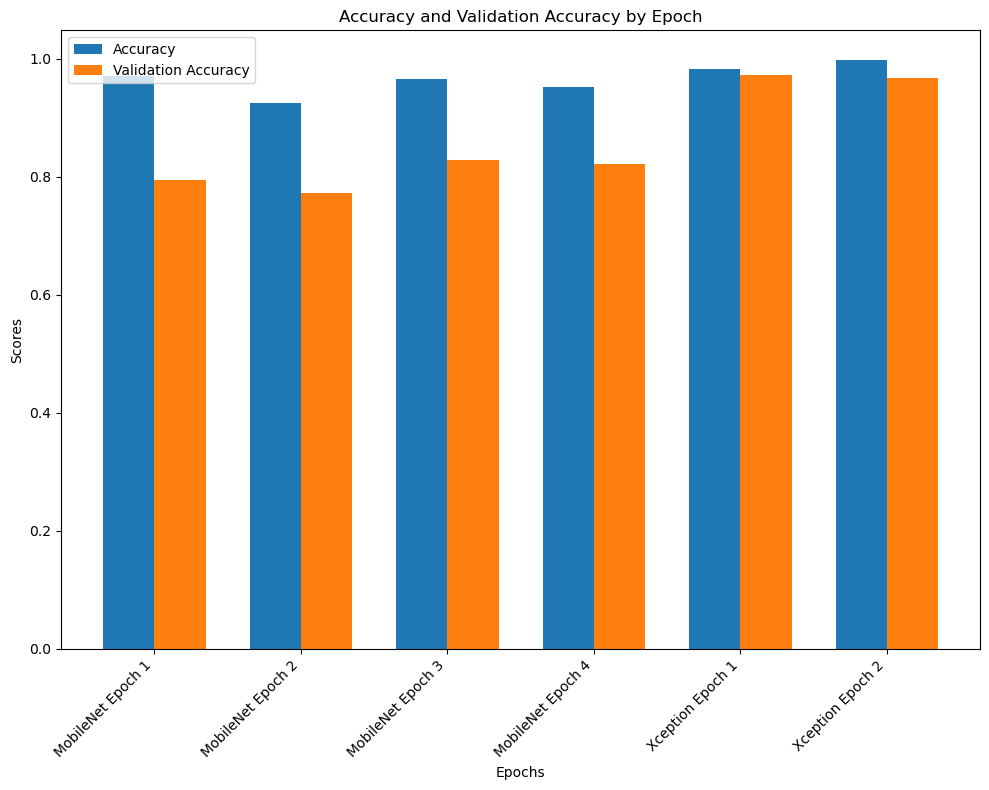

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
labels = [
    'MobileNet Epoch 1', 'MobileNet Epoch 2', 'MobileNet Epoch 3',
    'MobileNet Epoch 4', 'Xception Epoch 1', 'Xception Epoch 2'
]

acc = [
    0.9714, 0.9254, 0.9661,
    0.9522, 0.9828, 0.9981
]

val_acc = [
    0.7944, 0.7722, 0.8278,
    0.8222, 0.9722, 0.9667
]

# 그래프 그리기
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Epochs')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and Validation Accuracy by Epoch')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

fig.tight_layout()

plt.show()


## 6. 결론
- 모델 선택: MobileNet 모델과 Xception 모델을 사용하였으며, 초기 훈련부터 정확도(acc)가 0.8 이상인 수치를 보여주었습니다.
- 모델 성능 개선: Xception 모델을 사용하여 여러 채널 사이즈를 변경하며 모델의 정확도를 높이고자 하였습니다.
- 과적합 방지: 저용량 데이터셋이며 이미자가 많지 않아, 데이터 증강을 통해 모델의 일반화를 시도하였습니다.
- 모델 일반화: 데이터 증강, 규제(L2 규제) 및 드롭아웃 비율 조정 등을 통해 모델의 일반화를 이루었으며, 이러한 과정에서 과적합과 과소적합을 조절하는 방법을 확인하였습니다.

## 7. 느낀점
- 이미지의 패턴을 찾는 데 있어서, 주위 배경보다 중심에 있는 주요 이미지가 얼마나 잘 드러나는지가 중요한 부분임을 깨달았습니다.
- 주요 패턴을 찾기 위해서는 복잡한 이미지보다는 단순한 중심 이미지를 사용하는 것이 매우 중요하다는 것을 느꼈습니다.